In [1]:
import tensorflow as tf 
import keras 
import numpy as np 
import matplotlib

In [2]:

@keras.saving.register_keras_serializable()
def positionalEncoding (d_model,position) :
    position = np.arange(position)[:,np.newaxis]
    dim = np.arange(d_model)[np.newaxis,:]
    div_values = np.power(10000,(2* dim //2)) / tf.cast(d_model,dtype=tf.float32)
    div_values= np.maximum(div_values,1e-9)
    angle_rads = position * div_values
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])
    return tf.cast(angle_rads,dtype=tf.float32)

In [3]:
@keras.saving.register_keras_serializable()
class SelfAttention(keras.layers.Layer):
    def __init__(self, key_dim):
        super(SelfAttention, self).__init__()
        self.key_dim = key_dim

    def build(self, input_shape):
        features = input_shape[-1]
        self.Wq = self.add_weight(shape=(features, self.key_dim), trainable=True, initializer="random_normal")
        self.Wk = self.add_weight(shape=(features, self.key_dim), trainable=True, initializer="random_normal")
        self.Wv = self.add_weight(shape=(features, self.key_dim), trainable=True, initializer="random_normal")

    def call(self, x):
        q = tf.matmul(x, self.Wq)
        k = tf.matmul(x, self.Wk)
        v = tf.matmul(x, self.Wv)
        key_dim = tf.cast(self.key_dim, tf.float32)
        scores = tf.matmul(q, tf.transpose(k, perm=[0, 2, 1])) / tf.math.sqrt(key_dim)
        weights = tf.nn.softmax(scores, axis=-1)
        attention = tf.matmul(weights, v)
        return attention

    def get_config(self):
        config = super().get_config()
        config.update({
            "key_dim": self.key_dim
        })
        return config


In [4]:
@keras.saving.register_keras_serializable()
class BlockEncoder(keras.layers.Layer):
    def __init__(self, d_model, ffn, drop_rate=0.1, epsilon=1e-6):
        super(BlockEncoder, self).__init__()
        self.d_model = d_model
        self.ffn = ffn
        self.drop_rate = drop_rate
        self.epsilon = epsilon

        self.Attention = SelfAttention(d_model)
        self.Feed_forward_nn = keras.Sequential([
            keras.layers.Dense(ffn, activation=keras.activations.swish),
            keras.layers.Dense(d_model)
        ])
        self.Normal1 = keras.layers.LayerNormalization(epsilon=epsilon)
        self.Normal2 = keras.layers.LayerNormalization(epsilon=epsilon)
        self.dropout1 = keras.layers.Dropout(drop_rate)
        self.dropout2 = keras.layers.Dropout(drop_rate)

    def call(self, x):
        attn = self.Attention(x)
        attn = self.dropout1(attn)
        attn = self.Normal1(attn + x)
        ffn = self.Feed_forward_nn(attn)
        ffn = self.dropout2(ffn)
        ffn = self.Normal2(ffn + attn)
        return ffn

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "ffn": self.ffn,
            "drop_rate": self.drop_rate,
            "epsilon": self.epsilon
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [35]:
data = tf.random.normal((1000,140,8))

In [40]:
layers = BlockEncoder(d_model=8,ffn=16)

In [5]:
@keras.saving.register_keras_serializable()
class Tetha(keras.Model):
    def __init__(self, vocab_Size, drop_rate, num_layers=32, epsilon=1e-6, maxpos=100):
        super(Tetha, self).__init__()
        self.vocab_Size = vocab_Size
        self.drop_rate = drop_rate
        self.num_layers = num_layers
        self.epsilon = epsilon
        self.maxpos = maxpos
        
        self.Embedding = keras.layers.Embedding(vocab_Size, 16)
        self.BlockEncod = [BlockEncoder(16, 32, drop_rate=drop_rate, epsilon=epsilon) for _ in range(num_layers)]
        self.PosEncoding = self.add_weight(
            shape=positionalEncoding(16, maxpos).shape,
                    initializer=tf.constant_initializer(positionalEncoding(16, maxpos).numpy()),
                    trainable=False,
                    name="positional_encoding"
                )

    
    def call(self, x):
        seq_len = x.shape[1]
        x = self.Embedding(x)
        x += self.PosEncoding[:seq_len, :]
        for block in self.BlockEncod:
            x = block(x)
        return x

    def get_config(self):
        return {
            "vocab_Size": self.vocab_Size,
            "drop_rate": self.drop_rate,
            "num_layers": self.num_layers,
            "epsilon": self.epsilon,
            "maxpos": self.maxpos
        }



In [6]:
class Tiny_sentiment (keras.Model) : 
    def __init__ (self,Tetha) :
        super (Tiny_sentiment, self).__init__ ()
        self.Encoders = Tetha
        self.Pooling = keras.layers.GlobalAveragePooling1D()
        self.Dense = keras.layers.Dense(32,activation='relu')
        self.Out = keras.layers.Dense(1,activation='sigmoid')
    
    def call(self,x) :
        x = self.Encoders(x)
        x = self.Pooling(x)
        x = self.Dense(x)
        x = self.Out(x)
        return x 

In [7]:
import json

In [8]:
with open("Sarcasm_Headlines_Dataset.json",mode='r') as f :
    data = f.readlines()

In [9]:
datasets = list() 
for line in data:
    try:
        datasets.append(json.loads(line))
    except json.JSONDecodeError as e:
        print(f"Skipping invalid JSON line: {line.strip()} - Error: {e}")

In [11]:
datasets

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [65]:
x_data = list()
y_data = list() 
for i in datasets :
    x_data.append(i['headline'])
    y_data.append(i['is_sarcastic'])

In [11]:
y_data =np.array(y_data).reshape(-1,1)


In [12]:
max(len(i)for i in x_data)

254

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
tokenizers = Tokenizer()
tokenizers.fit_on_texts(x_data)

In [15]:
vocab_size = len(tokenizers.index_word) + 1

In [18]:
data = positionalEncoding(16,200)

In [115]:
data[:28,:]

<tf.Tensor: shape=(28, 16), dtype=float32, numpy=
array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 6.2459316e-02, -9.8438728e-01,  6.1625594e-01,  1.0000000e+00,
         6.4086425e-01, -3.9428774e-01,  9.9999997e-10,  6.2632298e-01,
         9.9999997e-10,  1.0000000e+00,  9.9999997e-10,  1.0000000e+00,
         9.9999997e-10,  1.0000000e+00,  9.9999997e-10,  1.0000000e+00],
       [ 1.2467473e-01,  9.3803656e-01, -9.7065973e-01,  1.0000000e+00,
        -9.8392427e-01, -6.8907434e-01,  1.9999999e-09, -2.1543904e-01,
         1.9999999e-09,  1.0000000e+00,  1.9999999e-09,  1.0000000e+00,
         1.9999999e-09,  1.0000000e+00,  1.9999999e-09,  1.0000000e+00],
       [ 1.8640329e-01, -8.6239517e-01,  9.1262233e-01,  1.0000000e+00,
         8.

In [16]:
x_data = tokenizers.texts_to_sequences(x_data)
x_data = pad_sequences(x_data,padding='post')

In [17]:
vocab_size

29657

In [69]:
tetha_models = Tetha(vocab_Size=vocab_size,drop_rate=0.1,maxpos=200,num_layers=20)

In [70]:
Pre_training_level1 = Tiny_sentiment(Tetha=tetha_models)

In [71]:
Pre_training_level1.summary()

Model: "tiny_sentiment_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_7 (Tetha)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,200 (12.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,200 (12.50 KB)

In [29]:
datasets = tf.data.Dataset.from_tensor_slices((x_data,y_data),name="sarcasm")

In [20]:
loss_fn = keras.losses.BinaryCrossentropy()
optimizers = keras.optimizers.AdamW(learning_rate=0.001)

In [21]:
for epoch in range(100) : 
    with tf.GradientTape() as tape : 
        for idx,(x_train,y_train) in enumerate(datasets) : 
            y_pred = Models_Experiment1(x_train)
            loss = loss_fn(y_train,y_pred)
        
        gradients = tape.gradient(loss, Models_Experiment1.trainable_variables)
        optimizers.apply(zip(gradients),Models_Experiment1.trainable_variables)
    
    if epoch % 10 == 0 :
        print(f"epoch : {epoch} || Loss : {loss:.9f}")

IndexError: Exception encountered when calling Encoders.call().

[1mtuple index out of range[0m

Arguments received by Encoders.call():
  • x=tf.Tensor(shape=(40,), dtype=int32)

In [76]:
y_data = np.array(y_data).reshape(-1,1)

In [77]:
Pre_training_level1.compile(optimizer=keras.optimizers.Adamax(),
                           loss=keras.losses.BinaryCrossentropy(),
                           metrics=[keras.metrics.Accuracy()])

In [78]:
vocab_size

29670

In [79]:
Pre_training_level1.fit(x_data,y_data,verbose=1,epochs=10)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 221s 153ms/step - accuracy: 0.0000e+00 - loss: 0.6914
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.0000e+00 - loss: 0.6875
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 125s 150ms/step - accuracy: 0.0000e+00 - loss: 0.6562
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 128s 153ms/step - accuracy: 0.0000e+00 - loss: 0.3868
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 134s 160ms/step - accuracy: 0.0000e+00 - loss: 0.3331
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 148s 167ms/step - accuracy: 0.0000e+00 - loss: 0.2835
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 128s 153ms/step - accuracy: 0.0000e+00 - loss: 0.2423
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 153ms/step - accuracy: 0.0000e+00 - loss: 0.2161
Epoch 9/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 125s 150ms/step - accuracy: 0.0000e+00 - loss: 0.1936
Epoch 10/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.0000e+00 - loss: 0.1641


In [80]:
Pre_training_level1.Encoders.save("Tetha_01.keras")

In [83]:
Pre_training_level1.summary()

Model: "tiny_sentiment_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_7 (Tetha)                 │ ?                      │       516,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_330 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,543,333 (5.89 MB)

 Trainable params: 513,377 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 1,026,756 (3.92 MB)

In [81]:
Tetha_01 = keras.models.load_model("Tetha_01.keras")

In [82]:
Tetha_01.summary()

Model: "tetha_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 40, 16)         │       474,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_160               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_161               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_162               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_163               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_164               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_165               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_166               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_167               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_168               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_169               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_170               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_171               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_172               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_173               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_174               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_175               │ ?                      │         1,904 │
│ (BlockEncoder)                  │                        │             

 Total params: 516,000 (1.97 MB)

 Trainable params: 512,800 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [43]:
Pre_training_level1.predict(np.array([x_data[np.random.randint(1,5000)] for i in range(20)]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.03123199],
       [0.00342598],
       [0.4813888 ],
       [0.9857411 ],
       [0.876154  ],
       [0.00360149],
       [0.12894757],
       [0.14961241],
       [0.958282  ],
       [0.95085514],
       [0.82989186],
       [0.09228151],
       [0.00587279],
       [0.9850627 ],
       [0.25368634],
       [0.99688715],
       [0.95335954],
       [0.995285  ],
       [0.9971802 ],
       [0.99722344]], dtype=float32)

In [28]:
loss_Tetha = np.array([0.6904,0.6865,0.5715,0.4383,0.3481,0.2958,0.2600,0.2171,0.1932,0.1649])

In [24]:
RNN_Models = keras.Sequential([
    keras.layers.Embedding(vocab_size,16),
    keras.layers.LSTM(64,return_sequences=True,return_state=False),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(1,activation="sigmoid")]
)

In [25]:
RNN_Models.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
RNN_Models.compile(loss=keras.losses.BinaryCrossentropy(),optimizer="adam",metrics=['accuracy'])

In [27]:
RNN_Models.fit(x_data,y_data,epochs=10,verbose=1)

Epoch 1/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - accuracy: 0.7123 - loss: 0.5223
Epoch 2/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9210 - loss: 0.2082
Epoch 3/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - accuracy: 0.9605 - loss: 0.1091
Epoch 4/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9776 - loss: 0.0720
Epoch 5/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.9844 - loss: 0.0509
Epoch 6/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.9884 - loss: 0.0409
Epoch 7/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9910 - loss: 0.0323
Epoch 8/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9930 - loss: 0.0249
Epoch 9/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.9947 - loss: 0.0193
Epoch 10/10
835/835 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.9957 - loss: 0.0164


In [29]:
rnn_loss = np.array([0.5300,0.2025,0.1091,0.0783,0.0501,0.0387,0.0246,0.0246,0.0216,0.0160])

In [46]:
RNN_Models.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 40, 16)         │       474,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 40, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,535,669 (5.86 MB)

 Trainable params: 511,889 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,023,780 (3.91 MB)

In [31]:
loss = np.array([0.6866,0.6814,0.4856,0.3791,0.3323,0.2787,0.2403,0.2093,0.1955,0.1677])
range_d = np.arange(10)

In [33]:
import matplotlib.pyplot as plt

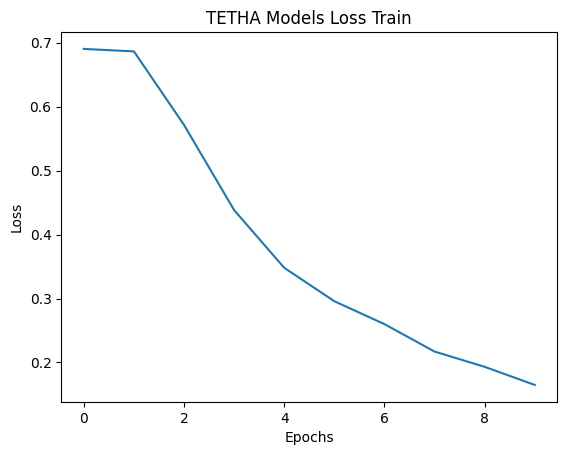

In [34]:
plt.plot(range_d,loss_Tetha)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("TETHA Models Loss Train")
plt.show()

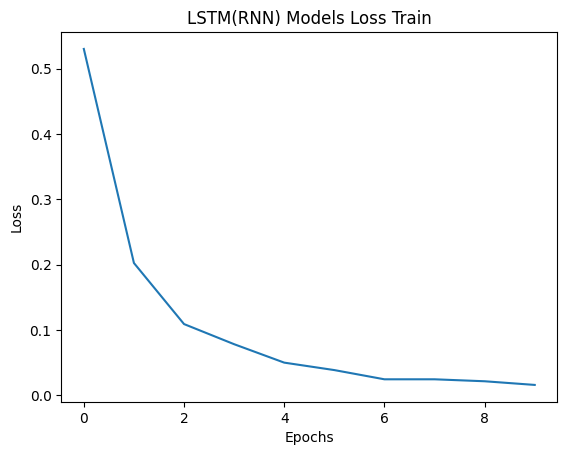

In [35]:
plt.plot(range_d,rnn_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("LSTM(RNN) Models Loss Train")
plt.show()

In [36]:
Pre_training_level1.summary()

Model: "tiny_sentiment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_1 (Tetha)                 │ ?                      │       512,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,539,509 (5.87 MB)

 Trainable params: 513,169 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,026,340 (3.92 MB)

In [37]:
Pre_training_level1.Encoders.summary()

Model: "tetha_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 16)         │       474,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_32 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_33 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_34 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_35 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_36 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_37 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_38 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_39 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_40 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_41 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_42 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_43 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_44 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_45 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_46 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_47 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_48 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_49 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_50 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_51 (BlockEncoder) │ ?                      │         1,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,592 (1.96 MB)

 Trainable params: 512,592 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
Pre_training_level1.Encoders.save("Tetha_v_01.keras")

In [39]:
models = keras.models.load_model("Tetha_v_01.keras")

TypeError: <class '__main__.Tetha'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'Tetha', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Custom>Tetha', 'build_config': {'input_shape': [None, 40]}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.Tetha'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of Tetha from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: Tetha.__init__() got an unexpected keyword argument 'trainable'

In [27]:
Models_Experiment1.Encoders.summary()

Model: "encoders"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 16)         │       474,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder (BlockEncoder)    │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_1 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_2 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_3 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_4 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_5 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_6 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_7 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_8 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_9 (BlockEncoder)  │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_10 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_11 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_12 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_13 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_14 (BlockEncoder) │ ?                      │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_encoder_15 (BlockEncoder) │ ?                      │         1,904 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,976 (1.93 MB)

 Trainable params: 504,976 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
data_test = ["Local man wins lottery, immediately regrets it.",
             "Scientists discover water is actually wet.",
             "World's happiest country elects most miserable leader."
             "New phone released, exactly like the old one.",
             "Study finds people like things that make them happy.",
             "Weather forecast predicts weather.",
             "Experts warn that warnings are being ignored."]

In [70]:
x_test = tokenizers.texts_to_sequences(data_test)

In [71]:
x_test = pad_sequences(x_test,maxlen=40,padding='post')

In [72]:
x_test

array([[ 188,   13,  505, 2950, 1572, 2754,   26,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 429,  808,  462,   10,  237, 3163,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 364, 4437,  433, 8616,   94, 5006,  710,   11,  498, 1315, 1524,
          57,    3,   60,   40,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  97,  124,   66,   57,  134,   27,   73,  221,  622,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [73]:
Models_Experiment1.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


array([[0.99832183],
       [0.87611014],
       [0.811449  ],
       [0.8942211 ],
       [0.03735373],
       [0.8810302 ]], dtype=float32)

In [74]:
RNN_Models.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


array([[9.99906719e-01],
       [9.99164581e-01],
       [9.99259174e-01],
       [9.40026790e-02],
       [1.11809066e-04],
       [9.99749660e-01]], dtype=float32)

In [21]:
NSP_data = ["The Horse Play in the garden ['SEP'] sky is blue",
            "kid eating a cake ['SEP'] them so happy and run by around",
            "someone making throwing a ball to the window ['SEP'] cause that the window ha broken ['SEP'] before being complict he run away",
            "Rabit run in jungle ['SEP'] and Mom cock a chicken soup",
            "I make cath so many Fish ['SEP'] this Animals so delicous if cocked to be fried fish ['SEP'] after cocking i'am so happy cause can eat Fried Fish",
            "Bank pay them worker in one mounth ['SEP'] so many People come bank for save their Finance ['SEP'] My way backhome will skipped Bank",
            "My Little Brother Like eat chocolate ['SEP'] cause that for him birth day i buy chocolate cake ['SEP'] he eat by happy feel",
            "I'am go to market ['SEP'] For buy a new toy",
            "I playing game ['SEP'] My friend got a new bag",
            "My girlfriend come to my room ['SEP'] She just sleep in my bed ['SEP'] when she weak up she huging me",
            "I buy a new eye glass ['SEP'] all dog in the garden feeling hungry",
            "The seafood is so delicous ['SEP'] tomorrow the new game will release",
            "all student in the classroom playing football ['SEP'] the teacher come and big angry",
            "i has did make so many biscuit ['SEP'] and Rainbow have seven colors",
            "My friend still working ['SEP'] so , i just waiting her for dinner together",
            "My bestfriends got a new phone ['SEP'] and today i want playing foot ball"]
label = [0,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0]

In [24]:
tokenizers.fit_on_texts(NSP_data)
NSP_train = tokenizers.texts_to_sequences(NSP_data)

In [25]:
y_label = np.array(label).reshape(-1,1)

In [26]:
NSP_train = pad_sequences(NSP_train,padding='post')

In [74]:
max(len(i) for i in NSP_train)

28

In [27]:
vocab_size = len(tokenizers.word_index) + 1

In [28]:
vocab_size

29670

In [84]:
class NSP_Classifier (keras.Model) :
    def __init__ (self,Model,Vocab_size) :
        super(NSP_Classifier,self).__init__()
        self.Tetha = Model
        self.Vocab_size = Vocab_size
        self.pooling = keras.layers.GlobalAveragePooling1D()
        self.Dense = keras.layers.Dense(64,activation='relu')
        self.Out = keras.layers.Dense(1,activation="sigmoid")

    
    def call(self,x) :
        x = self.Tetha(x)
        x = self.pooling(x)
        x = self.Dense(x)
        return self.Out(x)

In [131]:
NSP_Models = NSP_Classifier(Model=Tetha_01,Vocab_size=vocab_size)

In [132]:
NSP_Models.summary()

Model: "nsp__classifier_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_7 (Tetha)                 │ ?                      │       515,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_345 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,792 (1.97 MB)

 Trainable params: 512,592 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [133]:
NSP_Models.compile(loss=keras.losses.BinaryCrossentropy(),
                   optimizer=keras.optimizers.AdamW(),
                   metrics=['accuracy'])

In [135]:
NSP_Models.fit(NSP_train,y_label,verbose=1,epochs=30)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - accuracy: 0.5625 - loss: 0.6863
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - accuracy: 0.5625 - loss: 0.6855
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - accuracy: 0.5625 - loss: 0.6853
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5625 - loss: 0.6857
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5625 - loss: 0.6862
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.5625 - loss: 0.6865
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5625 - loss: 0.6863
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - accuracy: 0.5625 - loss: 0.6859
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - accuracy: 0.5625 - loss: 0.6855
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5625 - loss: 0.6853
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step - accuracy: 0.5625 - loss: 0.6854
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - accuracy: 0.5625 - lo

In [67]:
NSP_Models.summary()

Model: "nsp__classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_4 (Tetha)                 │ ?                      │       515,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,544,437 (5.89 MB)

 Trainable params: 513,745 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 1,027,492 (3.92 MB)

In [18]:
NSP_test_data = [
    "She loves to play guitar ['SEP'] Every night she practices until midnight",
    "The children are playing in the mud ['SEP'] Their clothes are all dirty now",
    "I bought some flowers for her ['SEP'] She smiled when I gave them",
    "He trained for months for the marathon ['SEP'] Finally, he completed it with pride",
    "My cat always sleeps on my bed ['SEP'] That’s why there’s fur all over the blanket",
    
    "I made a cake for her birthday ['SEP'] The dinosaur exhibit was amazing",
    "The doctor gave me some medicine ['SEP'] Penguins can't fly but they sure look fancy",
    "She cried after watching the movie ['SEP'] My shoes are made in Italy",
    "I bought a new laptop yesterday ['SEP'] Bananas are yellow and full of potassium",
    "He failed the exam again ['SEP'] Obviously, he’s a genius who doesn’t need to study"
]

NSP_test_label = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [19]:
X_test = tokenizers.texts_to_sequences(NSP_test_data)

In [105]:
X_test

[[142, 1371, 1, 633, 3318, 141, 229, 142, 6962, 445, 3406],
 [3, 288, 29, 849, 4, 3, 10034, 88, 1922, 29, 34, 2345, 68],
 [79, 3835, 155, 7343, 5, 58, 142, 84, 79, 1062, 221],
 [33, 9378, 5, 591, 5, 3, 4503, 232, 33, 9314, 26, 9, 1637],
 [78, 553, 444, 5363, 7, 78, 1356, 44, 9907, 34, 47, 3, 7317],
 [79, 203, 6, 1757, 5, 58, 593, 3, 8282, 3171, 74, 998],
 [3, 958, 1062, 267, 155, 2875, 9986, 119, 2509, 115, 96, 402, 178, 7432],
 [142, 8273, 20, 629, 3, 292, 78, 2695, 29, 203, 4, 2752],
 [79, 3835, 6, 11, 3213, 10760, 5897, 29, 6960, 8, 378, 2],
 [33, 1421, 3, 7136, 206, 3289, 6, 2708, 36, 145, 1, 97]]

In [106]:
X_test = pad_sequences(X_test, padding='post',maxlen=200)

In [107]:
X_test

array([[ 142, 1371,    1, ...,    0,    0,    0],
       [   3,  288,   29, ...,    0,    0,    0],
       [  79, 3835,  155, ...,    0,    0,    0],
       ...,
       [ 142, 8273,   20, ...,    0,    0,    0],
       [  79, 3835,    6, ...,    0,    0,    0],
       [  33, 1421,    3, ...,    0,    0,    0]])

In [83]:
NSP_Models.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


array([[0.96401155],
       [0.96402395],
       [0.9640219 ],
       [0.96401656],
       [0.9640188 ],
       [0.96402377],
       [0.96401715],
       [0.9640132 ],
       [0.96402603],
       [0.9640239 ]], dtype=float32)

In [87]:
Tetha_models = keras.models.load_model("Tetha_01.keras")

In [90]:
NSP_Training = NSP_Classifier(Model=Tetha_models,Vocab_size=vocab_size)

In [91]:
NSP_Training.summary()

Model: "nsp__classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_9 (Tetha)                 │ ?                      │       516,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,000 (1.97 MB)

 Trainable params: 512,800 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [92]:
X_data = tokenizers.texts_to_sequences(NSP_data)

In [94]:
X_data = pad_sequences(X_data,padding='post')

In [95]:
Y_data = np.array(label).reshape(-1,1)

In [97]:
NSP_Training.compile(loss=keras.losses.BinaryCrossentropy(),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])

In [100]:
NSP_Training.fit(X_data,Y_data,verbose=1,epochs=20)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5625 - loss: 0.5973
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7500 - loss: 0.5784
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8125 - loss: 0.5673
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8750 - loss: 0.5445
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8750 - loss: 0.5222
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8750 - loss: 0.5094
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8750 - loss: 0.4856
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8750 - loss: 0.4709
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8750 - loss: 0.4445
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9375 - loss: 0.4172
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9375 - loss: 0.3964
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9375 - lo

In [108]:
NSP_Training.summary()

Model: "nsp__classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha_9 (Tetha)                 │ ?                      │       516,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,545,061 (5.89 MB)

 Trainable params: 513,953 (1.96 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 1,027,908 (3.92 MB)

In [110]:
NSP_Training.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


array([[0.7132852 ],
       [0.7756928 ],
       [0.7774805 ],
       [0.7536675 ],
       [0.7733803 ],
       [0.7873089 ],
       [0.7715226 ],
       [0.76181877],
       [0.77713317],
       [0.763573  ]], dtype=float32)

In [111]:
NSP_Training.Tetha.save("Tetha_011.keras")

In [22]:
tokenizers.fit_on_texts(NSP_data)

In [23]:
Tetha_models = keras.models.load_model("Tetha_011.keras")

In [61]:
class BlockDecoder (keras.Model) :
    def __init__ (self,d_model,drop_rate,num_head,ffn) : 
        super(BlockDecoder,self).__init__()
        self.Attention = keras.layers.MultiHeadAttention(num_heads=num_head,key_dim=(d_model//num_head),dropout=drop_rate)
        self.Feed_forward = keras.Sequential([
            keras.layers.Dense(ffn,activation=keras.activations.leaky_relu),
            keras.layers.Dense(d_model)
        ])
        self.Normal1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.Normal2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = keras.layers.Dropout(drop_rate)
    
    def call (self,x) : 
        x_inc,x_dec = x
        attn = self.Attention(x_dec,x_inc,x_inc)
        attn = self.Normal1 (attn + x_dec)
        ffn = self.Feed_forward(attn)
        ffn = self.dropout(ffn)
        ffn = self.Normal2(ffn + attn)
        return ffn 

In [28]:
Tetha_models(np.array([x_data[0],x_data[1]]))

<tf.Tensor: shape=(2, 40, 16), dtype=float32, numpy=
array([[[ 0.273767  , -1.8070039 , -0.26511192, ..., -0.9813329 ,
          0.22589159, -0.25429505],
        [ 0.4991622 , -1.9198964 , -0.42817613, ..., -0.7615715 ,
          0.27676225, -0.24826652],
        [ 0.39774787, -1.794446  , -0.39666343, ..., -0.85011584,
          0.23250473, -0.2709005 ],
        ...,
        [ 0.46390653, -1.8226066 , -0.38500583, ..., -0.70052606,
          0.22539617, -0.23073412],
        [ 0.50971097, -1.8130455 , -0.3951202 , ..., -0.54203045,
          0.22333953, -0.21871376],
        [ 0.4987446 , -1.8418117 , -0.36488098, ..., -0.633159  ,
          0.22938912, -0.21209142]],

       [[ 1.2525179 ,  0.87244344, -0.4653322 , ...,  0.07877425,
         -0.11555166,  0.621897  ],
        [ 0.1541835 ,  0.8224497 , -0.79839426, ...,  0.69160366,
          0.50493515, -0.68103904],
        [-0.19145355,  1.1772399 , -2.2128036 , ...,  0.5876623 ,
          0.7605696 , -1.6788559 ],
        ...,
 

In [30]:
dat = Tetha_models(np.array([x_data[0],x_data[1]]))

In [32]:
dense = keras.layers.Dense(64,activation=keras.activations.swish)

In [62]:
class Decoder (keras.Model) : 
    def __init__ (self,vocab_size,d_model=16,drop_rate=0.1,num_head=4,ffn=32,num_layers = 4) : 
        super(Decoder,self).__init__()
        self.BlockDecoder = [BlockDecoder(d_model,drop_rate,num_head,ffn) for _ in range(num_layers)]
        self.Embedding = keras.layers.Embedding(vocab_size,d_model)
        self.posencoding = positionalEncoding(d_model=d_model,position=200)
        self.Linear = keras.layers.Dense(64,activation='relu')
        self.outputs_ = keras.layers.Dense(vocab_size,activation='softmax')
        self.Trans_linear = keras.layers.Dense(d_model)
        self.multiHeadAttention = keras.layers.MultiHeadAttention(num_heads=num_head,key_dim=(d_model//num_head))
        self.Normal1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.Normal2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.Normal3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.feed_forward = keras.Sequential([
            keras.layers.Dense(ffn),
            keras.layers.Dense(d_model)
        ])
        self.dropout = keras.layers.Dropout(drop_rate)
        self.dropout2 = keras.layers.Dropout(drop_rate)
    
    def call(self,x) : 
        decoder_input,encoder_out = x 
        seq_len = tf.shape(decoder_input)[1]
        encoder_out = self.Trans_linear(encoder_out)
        decod_in  = self.Embedding(decoder_input)
        decod_in += self.posencoding[:seq_len,:]
        attn_decod = self.multiHeadAttention(decod_in,decod_in,decod_in,use_causal_mask=True)
        attn_decod = self.Normal1(attn_decod + decod_in)

        for layers in self.BlockDecoder : 
            x_input = layers([encoder_out,attn_decod])
        x_input = self.dropout(x_input)
        x_input = self.Normal2(x_input + attn_decod)

        ffn = self.feed_forward(x_input)
        ffn = self.dropout2(ffn)
        ffn = self.Normal3(ffn + x_input)

        out = self.Linear(ffn)
        out = self.outputs_(out)
        return out

        
        

In [64]:
datasets

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [48]:
decoder_models = Decoder(vocab_size=vocab_size,d_model=32)

In [66]:
x_data = list()
y_data = list() 
for i in datasets :
    x_data.append(i['headline'])
    y_data.append(i['is_sarcastic'])

In [72]:
import random

def acak_kalimat(kalimat):
    # Pisahkan kalimat menjadi list kata
    kata_list = kalimat.split()
    # Acak urutan kata
    random.shuffle(kata_list)
    # Gabungkan kembali menjadi string
    return ' '.join(kata_list)

# Contoh pakai
kalimat = "Aku makan nasi di rumah"
hasil = acak_kalimat(kalimat)
print(hasil)


di makan Aku rumah nasi


In [75]:
x_train = [acak_kalimat(x) for x in x_data]

In [78]:
tokenizers.fit_on_texts(['[SOS]','[EOS]'])

In [79]:
x_train_enc = x_train
x_train_dec = ['[SOS]' + l + '[EOS]' for l in x_train]

In [80]:
x_train_enc = tokenizers.texts_to_sequences(x_train_enc)
x_train_dec = tokenizers.texts_to_sequences(x_train_dec)
y_train = tokenizers.texts_to_sequences(x_data)

In [83]:
x_train_enc = pad_sequences(x_train_enc,padding='post',maxlen=45)
x_train_dec = pad_sequences(x_train_dec,padding='post',maxlen=45)
y_train = pad_sequences(y_train,padding='post',maxlen=45)

In [84]:
vocab_size = len(tokenizers.index_word) + 1

In [90]:
class ReconstructorModels (keras.Model) : 
    def __init__ (self,Tetha,Decoder) :
        super(ReconstructorModels,self).__init__()
        self.Tetha = Tetha
        self.Decoder = Decoder 
    
    def call(self,x) :
        enc_input,dec_input = x 
        enc_out = self.Tetha(enc_input)
        output = self.Decoder([dec_input,enc_out])
        return output

In [91]:
decoders = Decoder(vocab_size=vocab_size,d_model=32)


In [92]:
recontructor = ReconstructorModels(Tetha= Tetha_models,Decoder=decoders)

In [93]:
recontructor.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                     optimizer=keras.optimizers.AdamW(),
                     metrics=['accuracy'])

In [100]:
sample_x_dec =  x_train_dec[:1000]
sample_x_enc = x_train_enc[:1000]
sample_y = y_train[:1000]

In [111]:
recontructor.fit([sample_x_enc,sample_x_dec],sample_y,epochs=10,verbose=1)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 729ms/step - accuracy: 0.7919 - loss: 1.1623
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 713ms/step - accuracy: 0.7991 - loss: 1.1011
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 739ms/step - accuracy: 0.8040 - loss: 1.0708
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 792ms/step - accuracy: 0.8103 - loss: 1.0250
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 712ms/step - accuracy: 0.8177 - loss: 0.9838
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 740ms/step - accuracy: 0.8219 - loss: 0.9570
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 791ms/step - accuracy: 0.8323 - loss: 0.9010
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 795ms/step - accuracy: 0.8420 - loss: 0.8633
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 725ms/step - accuracy: 0.8558 - loss: 0.8086
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 800ms/step - accuracy: 0.8600 - loss: 0.7851


In [107]:
accuracy = np.array([0.5765,0.7768,0.7780,0.7754,0.7773,0.7772,0.7775,0.7776,0.7804,0.7826])

In [103]:
loss = np.array([9.6085,4.3456,2.0363,1.8334,1.7570,1.6971,1.6605,1.6068,1.5275,1.4634])

In [104]:
import matplotlib.pyplot as plt

[]

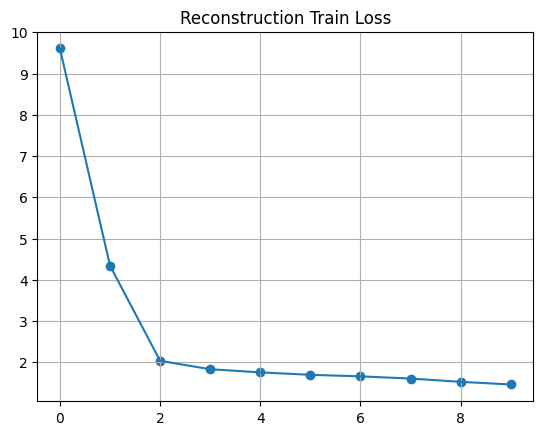

In [ ]:
plt.plot(np.arange(10),loss)
plt.scatter(np.arange(10),loss)
plt.grid(True)
plt.title("Reconstruction Train Loss")
plt.plot()

[]

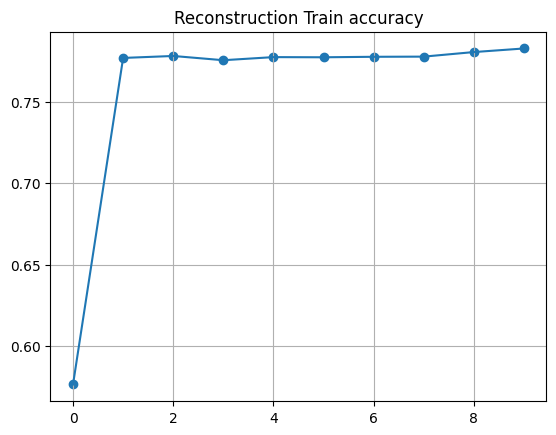

In [109]:
plt.plot(np.arange(10),accuracy)
plt.scatter(np.arange(10),accuracy)
plt.grid(True)
plt.title("Reconstruction Train accuracy")
plt.plot()

In [112]:
recontructor.summary()

Model: "reconstructor_models"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tetha (Tetha)                   │ ?                      │       516,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Decoder)             │ ?                      │     2,913,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,281,274 (39.22 MB)

 Trainable params: 3,426,024 (13.07 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 6,852,050 (26.14 MB)

In [114]:
test = [sample_x_enc,sample_x_dec]

In [ ]:
predict = recontructor.predict(test)

31/32 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000023C336DF020>>
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 
